In [1]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq
import seaborn as sns; sns.set()

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"
TABLE_NAME = "res_tickers_history"

warnings.filterwarnings("ignore")

In [5]:
def query_ticker_data(ticker):
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_history`
        WHERE ticker = '{ticker}'
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df

In [11]:
apple = query_ticker_data('AAPL').set_index('date')
netflix = query_ticker_data('NFLX').set_index('date')
meta = pd.read_gbq("SELECT * FROM `new-life-400922.etl.res_tickers_by_month` WHERE ticker = 'META' AND date >'2022-06-09'", project_id=PROJECT_ID, dialect="standard").set_index('date')
fb = query_ticker_data('FB').set_index('date')
fb_meta = pd.concat([meta, fb])
microsoft = query_ticker_data('MSFT').set_index('date')
amazon = query_ticker_data('AMZN').set_index('date')
alphabet = query_ticker_data('GOOGL').set_index('date')
coke = query_ticker_data('KO').set_index('date')

apple.name = "Apple"
netflix.name = "Netflix"
fb.name = "Facebook"
meta.name = "Meta"
fb_meta.name = "Facebook / Meta"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

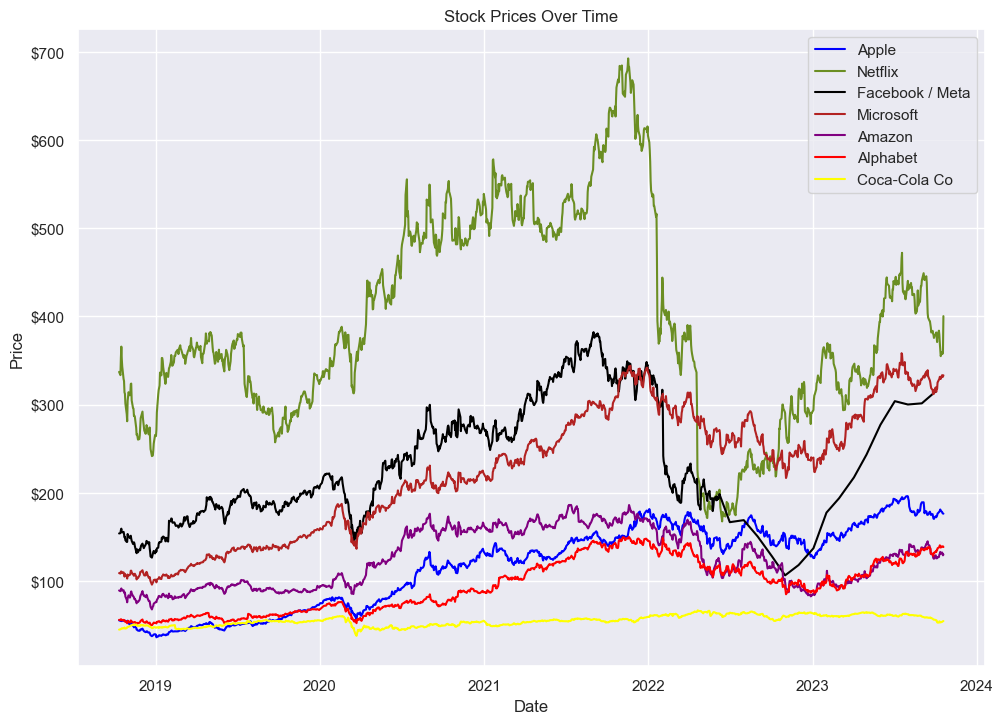

In [12]:
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

company = [apple, netflix, fb_meta, microsoft, amazon, alphabet, coke]
color = ['blue', 'olivedrab','black','firebrick','purple', 'red', 'yellow']    
for cmp, clr in zip(company,color):
    ax = sns.lineplot(data=cmp,x="date",y="volume_weighted_average_price",color=clr,label=cmp.name)
    ax.set(xlabel='Date',
       ylabel='Price',
       title='Stock Prices Over Time')
    ticks = ax.get_yticks()
    # formatted the values into strings beginning with dollar sign
    new_labels = [f'${int(amt)}' for amt in ticks]
    # Set the new labels
    ax.set_yticklabels(new_labels)    

plt.show()